<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data and preprocess

In [73]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

from IPython import display

In [74]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [75]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). 
# We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
test_images = images[10000:12500]

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). 
# We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


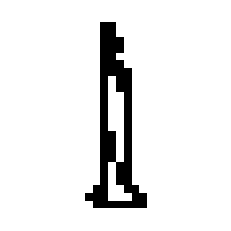

In [76]:
%matplotlib inline

def preprocess(data):
    """Preprocess the data for use in the GAN"""
    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.map(lambda x: tf.reshape(x, shape=(28,28,1)))
    data = data.map(lambda x: tf.cast(x, tf.float32))
    data = data.map(lambda x: (x/128.-1.))

    data = data.shuffle(1028).batch(32).prefetch(tf.data.AUTOTUNE)

    return data

train_ds = preprocess(train_images)
test_ds = preprocess(test_images)

# Display one exampe image of a candle
for x in train_ds.take(1):
    img = tf.cast(tf.floor(x*128+1), tf.uint32)[-1,:,:,-1]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

## Models for Discriminator, Generator and GAN

In [77]:
class Discriminator(tf.keras.Model):
    """Model for the discriminator, input = images with shape (batch,28,28,1), returns a 1d-laten-space-vector"""
    def __init__(self): 
        super(Discriminator, self).__init__()
        self.cnn = [tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='leaky_relu'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.GlobalMaxPool2D(),
                    tf.keras.layers.Dense(1,activation='sigmoid')]

    def __call__(self, x, training=False):
        for layer in self.cnn:
            x = layer(x, training=training)
        return x

In [78]:
class Generator(tf.keras.Model):
    """Model for the generator, input = 1d-laten-space-vector, returns a generated image"""
    def __init__(self):
        super(Generator, self).__init__()
        self.cnnT = [tf.keras.layers.Dense(98),
                     tf.keras.layers.Reshape((7,7,2)),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same', activation='relu'),
                     tf.keras.layers.BatchNormalization(),
                     #tf.keras.layers.Dropout(0.5), kernel_regularizer=tf.keras.regularizers.L2(0.001),
                     tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same', activation='relu'),
                     tf.keras.layers.BatchNormalization(),
                     #tf.keras.layers.Dropout(0.5),
                     tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='tanh')]
    
    def __call__(self, x, training=False):
        for layer in self.cnnT:
            x = layer(x, training=training)
        return x

In [79]:
class GAN(tf.keras.Model):
    """Model for the GAN - consisting of Discriminator and Generator, 
    input = noise to create images from and real images"""
    def __init__(self):
        super(GAN, self).__init__()
        self.disc = Discriminator()
        self.gen = Generator()

        self.loss = tf.keras.losses.BinaryCrossentropy()
        # Initialize two optimizers to optimize both models separately
        self.opt_disc = tf.keras.optimizers.Adam()
        self.opt_gen = tf.keras.optimizers.Adam()

        self.metrics_list = [tf.keras.metrics.Mean(name="loss discriminator"), 
                             tf.keras.metrics.Mean(name="loss generator")]

    def __call__(self, noise, input, training=False):
        # Generator creates fake images from input noise
        out_gen = self.gen(noise, training=training) #gen_fake_img

        # Discriminator gets fake and real images as input, 
        # returns result on if it is a real or fake image
        fake = self.disc(out_gen, training=training)
        real = self.disc(input, training=training)

        return fake, real

    def noise_f(self):
        """Function to create noise to use in creating fake images"""
        return tf.random.normal(shape=(32,1,98))

    @property
    def metrics(self):
        return self.metrics_list
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    @tf.function
    def train(self,x):
        # Initialize noise
        noise = self.noise_f()

        # Use two GradientTapes on discriminator and generator to optimize 
        # each model separately
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

            # y1 = fake output, y2 = real output
            y1,y2 = self(noise, x, training=True)
            # Create targets for fake (=0) and real images (=1)
            fake_t, real_t = tf.zeros_like(y1), tf.ones_like(y2)

            # Calculate BCE loss for fake and real images,
            # combination of both is the discriminator loss
            loss_f = self.loss(fake_t, y1)
            loss_r = self.loss(real_t, y2)
            loss_disc = loss_f + loss_r

            # Loss of Generator is calculated on how much fake images are
            # rated as real (target=1)
            loss_gen = self.loss(tf.ones_like(y1), y1)

        # Optimize Discriminator and Generator separately
        gradients_disc = disc_tape.gradient(loss_disc, self.disc.trainable_variables)
        gradients_gen = gen_tape.gradient(loss_gen, self.gen.trainable_variables)
        self.opt_disc.apply_gradients(zip(gradients_disc, self.disc.trainable_variables))
        self.opt_gen.apply_gradients(zip(gradients_gen, self.gen.trainable_variables))

        self.metrics[0].update_state(loss_disc)
        self.metrics[1].update_state(loss_gen)

        return {m.name : m.result() for m in self.metrics}
    
    @tf.function
    def test(self,x):
        # For additional comments look at train function
        noise = self.noise_f()

        y1,y2 = self(noise, x, training=True)
        fake_t, real_t = tf.zeros_like(y1), tf.ones_like(y2)

        loss_f = self.loss(fake_t, y1)
        loss_r = self.loss(real_t, y2)
        loss = loss_f + loss_r

        loss_gen = self.loss(tf.ones_like(y1), y1)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(loss_gen)

        return {m.name : m.result() for m in self.metrics}

## Training

In [80]:
# Initialize GAN
model_test = GAN()
# Test model structure with dummy input
model_test(tf.ones((32,1,98)),tf.ones((32,28,28,1)));
#model_test.summary()

In [81]:
# Create random 1d-latent-space vector for generating images while training
lat_vec = np.random.normal(size=(1,98))

In [82]:
import tqdm

def training_loop(model, train, val, epochs, lat_vec):
    """Train and test the RNN for given epochs on given data"""

    # Save loss for Discriminator and Generator as dictionaries in a list for visualization
    lists = []
    # Save created images while training in list
    img = []

    for n in range(epochs):
        print(f"Epoch {n}:")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = model.train(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        for data in tqdm.tqdm(val, position=0, leave=True):
            metrics = model.test(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        # Create image from generator with random latent vector and save in list
        img.append(model.gen(lat_vec))
        
    return lists, img

li, img = training_loop(model_test, train_ds, test_ds, epochs=10, lat_vec=lat_vec)

Epoch 0:


100%|██████████| 313/313 [00:04<00:00, 75.55it/s]


['loss discriminator: 0.4835954010486603', 'loss generator: 2.935462713241577']


100%|██████████| 79/79 [00:00<00:00, 88.29it/s] 


['loss discriminator: 0.08681119233369827', 'loss generator: 3.9842584133148193']
Epoch 1:


100%|██████████| 313/313 [00:02<00:00, 154.57it/s]


['loss discriminator: 0.14891397953033447', 'loss generator: 3.4015660285949707']


100%|██████████| 79/79 [00:00<00:00, 257.41it/s]


['loss discriminator: 0.2280435860157013', 'loss generator: 3.3860573768615723']
Epoch 2:


100%|██████████| 313/313 [00:01<00:00, 158.17it/s]


['loss discriminator: 0.2001023143529892', 'loss generator: 3.2280213832855225']


100%|██████████| 79/79 [00:00<00:00, 251.49it/s]


['loss discriminator: 0.2589714229106903', 'loss generator: 2.6727097034454346']
Epoch 3:


100%|██████████| 313/313 [00:01<00:00, 157.05it/s]


['loss discriminator: 0.18910633027553558', 'loss generator: 3.3770575523376465']


100%|██████████| 79/79 [00:00<00:00, 234.75it/s]


['loss discriminator: 0.18638862669467926', 'loss generator: 4.216867446899414']
Epoch 4:


100%|██████████| 313/313 [00:02<00:00, 151.60it/s]


['loss discriminator: 0.16940264403820038', 'loss generator: 3.6296305656433105']


100%|██████████| 79/79 [00:00<00:00, 245.57it/s]


['loss discriminator: 0.12744146585464478', 'loss generator: 3.3249638080596924']
Epoch 5:


100%|██████████| 313/313 [00:01<00:00, 156.59it/s]


['loss discriminator: 0.22279581427574158', 'loss generator: 3.416400909423828']


100%|██████████| 79/79 [00:00<00:00, 245.35it/s]


['loss discriminator: 0.14948247373104095', 'loss generator: 3.6426379680633545']
Epoch 6:


100%|██████████| 313/313 [00:02<00:00, 154.96it/s]


['loss discriminator: 0.21776936948299408', 'loss generator: 3.5400631427764893']


100%|██████████| 79/79 [00:00<00:00, 247.01it/s]


['loss discriminator: 0.1402549147605896', 'loss generator: 2.930347204208374']
Epoch 7:


100%|██████████| 313/313 [00:01<00:00, 156.71it/s]


['loss discriminator: 0.1841619461774826', 'loss generator: 3.7136800289154053']


100%|██████████| 79/79 [00:00<00:00, 254.91it/s]


['loss discriminator: 0.1135658323764801', 'loss generator: 4.4444966316223145']
Epoch 8:


100%|██████████| 313/313 [00:02<00:00, 154.88it/s]


['loss discriminator: 0.16103504598140717', 'loss generator: 3.884079933166504']


100%|██████████| 79/79 [00:00<00:00, 211.99it/s]


['loss discriminator: 0.15206772089004517', 'loss generator: 3.129424810409546']
Epoch 9:


100%|██████████| 313/313 [00:02<00:00, 151.79it/s]


['loss discriminator: 0.21858207881450653', 'loss generator: 3.784379005432129']


100%|██████████| 79/79 [00:00<00:00, 244.67it/s]

['loss discriminator: 0.100962795317173', 'loss generator: 3.7750675678253174']


## Visualization

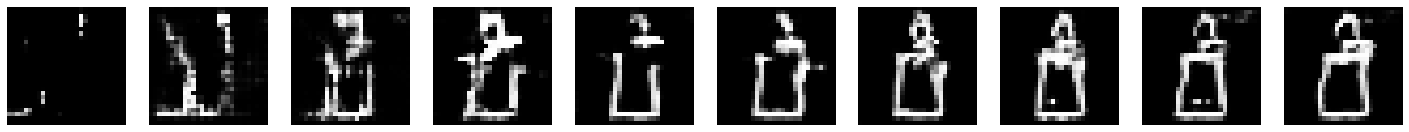

In [90]:
# Display the images created by the Generator while training
k = 1
plt.figure(figsize=(25,10))

for x in img:
    # Reduce dimensionality of images for displaying to 2D (remove batch and color channel)
    x = np.squeeze(x, axis=0)
    x = np.squeeze(x, axis=-1)
    plt.subplot(1, len(img), k)
    plt.imshow(x, cmap='gray')
    plt.axis('off')
    k += 1

plt.show()

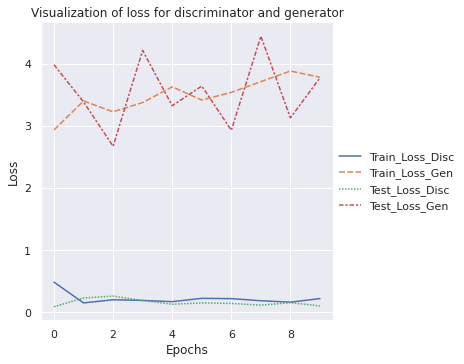

In [103]:
import seaborn as sns
%matplotlib inline

def visualization(lists):
    """Visualizes accuracy and loss for training and test data """

    # Create lists for each visualized metric
    epochs = np.array([*range(10)])
    train_loss_disc = np.zeros(epochs.size)
    train_loss_gen = np.zeros(epochs.size)
    test_loss_disc = np.zeros(epochs.size)
    test_loss_gen = np.zeros(epochs.size) 

    # Counter used for splitting the input
    c,i = 0,0
    # Split up the metrics to the corresponding arrays
    for k in range(len(lists)):
        if k%2 == 1:
            test_loss_disc[i] = lists[k]['loss discriminator'].numpy()
            test_loss_gen[i] = lists[k]['loss generator'].numpy()
            i += 1
        else:
            train_loss_disc[c] = lists[k]['loss discriminator'].numpy()
            train_loss_gen[c] = lists[k]['loss generator'].numpy()
            c += 1
    
    # Create dictionary with all 4 metrics
    data= {'Train_Loss_Disc':train_loss_disc, 'Train_Loss_Gen':train_loss_gen, 'Test_Loss_Disc':test_loss_disc, 'Test_Loss_Gen':test_loss_gen}

    # Plot the metrics
    sns.set_theme()
    sns.relplot(data=data, kind='line').set(title='Visualization of loss for discriminator and generator',xlabel='Epochs', ylabel='Loss')

visualization(li)

## Outstanding

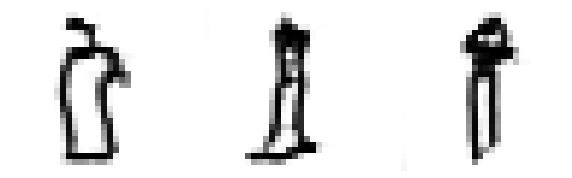

In [102]:
import datetime 

def is_it_christmas(model, datum):
    year = datum.year
    day = datum.day
    # Determine weekday of 
    xmas = datetime.date(year, 12, 24).isoweekday()
    # List to save created images
    img = []

    # If the 24th is Sunday -> 24th = 4th advent, 
    # otherwise subtract days until sunday (=7)
    if xmas == 7:
        vier = datetime.date(2022, 12, 24).day
    else:
        vier = datetime.date(2022, 12, 24-xmas).day

    # Depending on the date, create 3,4 or 5 candles
    if day < vier:
        for _ in range(3):
            img.append(model.gen(np.random.normal(size=(1,98))))
    if day >= vier and day < vier+7:
        for _ in range(4):
            img.append(model.gen(np.random.normal(size=(1,98))))
    if day > vier+7:
        for _ in range(5):
            img.append(model.gen(np.random.normal(size=(1,98))))
    
    # PLot the candles
    k=1
    for x in img:
        # Reduce dimensionality of images for displaying to 2D (remove batch and color channel)
        x = np.squeeze(x, axis=0)
        x = np.squeeze(x, axis=-1)
        plt.subplot(1, len(img),k)
        # 1-x to invert colors
        plt.imshow(1-x, cmap='gray')
        plt.axis('off')
        k += 1
    return

# Date of advent wreath
date = datetime.date(2022, 12, 16)

plt.figure(figsize=(10,5))
is_it_christmas(model_test, date)
plt.show()